In [1]:
if "google.colab" in str(get_ipython()):
    from google.colab import drive
    import os
    drive.mount("/content/gdrive")
    os.chdir("/content/gdrive/My Drive/CS4243 Project/temp")
    !pwd
    %pip install -q ipywidgets
    %pip install -q -r requirements_colab.txt
else:
    %pip install -q -r requirements.txt

# may need to restart the kernel after installing new packages

Note: you may need to restart the kernel to use updated packages.


# Baseline (Multi-Layer Perceptron)

In [2]:
%reset

import torch
import torch.nn as nn

import time

import numpy as np
import matplotlib.pyplot as plt

from utils import load_tensor

In [3]:
train_unaug_x, train_unaug_y = load_tensor("unaug", "32")
test_x, test_y = load_tensor("test", "32")

train_unaug_x.size(), train_unaug_x.type(), train_unaug_y.size()

(torch.Size([5500, 3, 32, 32]), 'torch.FloatTensor', torch.Size([5500]))

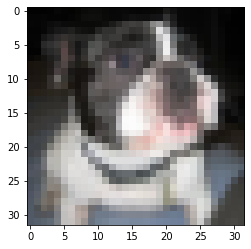

In [4]:
from utils import display_num_param, show, get_error

show(train_unaug_x[100])

## Build MLP

A 3-layer MLP

In [5]:
class three_layer_net(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size):
        super(three_layer_net , self).__init__()

        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, output_size)   
        
    def forward(self, x):
        y       = self.layer1(x)
        y_hat   = torch.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = torch.relu(z)
        scores  = self.layer3(z_hat)
        
        return scores

In [6]:
net=three_layer_net(3072,500,500,10)
print(net)
display_num_param(net)

three_layer_net(
  (layer1): Linear(in_features=3072, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=500, bias=True)
  (layer3): Linear(in_features=500, out_features=10, bias=True)
)
There are 1792010 (1.79 million) parameters in this neural network


### Define Hyper-parameters

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD( net.parameters() , lr=0.05 )
bs= 100

### Training

In [11]:
def eval_on_test_set():
    test_size = test_x.size(0)

    running_error=0
    num_batches=0

    for i in range(0,(test_size//bs)*bs,bs):

        minibatch_data =  test_x[i:i+bs]
        minibatch_label= test_y[i:i+bs]

        inputs = minibatch_data.view(bs,3072)

        scores=net( inputs ) 

        error = get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    print( 'test error  = ', total_error*100 ,'percent')

In [12]:
start=time.time()

for epoch in range(30):
    
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(train_unaug_x.size(0))
 
    for count in range(0, (train_unaug_x.size(0)//bs)*bs ,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_x =  train_unaug_x[indices]
        minibatch_y =  train_unaug_y[indices]
        
        # reshape the minibatch
        inputs = minibatch_x.view(bs,3072)  # to continuous tensor

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss = criterion(scores, minibatch_y) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error
        error = get_error( scores.detach() , minibatch_y)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = time.time()-start
    
    if epoch%1 == 0:
        print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        eval_on_test_set() 
        print(' ')

epoch= 0 	 time= 0.9480693340301514 	 loss= 1.776455241983587 	 error= 62.581818645650685 percent
test error  =  71.16666734218597 percent
 
epoch= 1 	 time= 1.7873270511627197 	 loss= 1.7788475253365257 	 error= 62.436363588679924 percent
test error  =  76.16666754086813 percent
 
epoch= 2 	 time= 2.918158531188965 	 loss= 1.7780145428397438 	 error= 63.018182407725945 percent
test error  =  71.99999988079071 percent
 
epoch= 3 	 time= 3.9500441551208496 	 loss= 1.7381556229157882 	 error= 60.30909126455134 percent
test error  =  75.16666650772095 percent
 
epoch= 4 	 time= 4.895110845565796 	 loss= 1.751868759502064 	 error= 62.109090848402545 percent
test error  =  74.83333349227905 percent
 
epoch= 5 	 time= 5.834079027175903 	 loss= 1.7246435685591264 	 error= 60.12727303938432 percent
test error  =  75.3333330154419 percent
 
epoch= 6 	 time= 6.992476463317871 	 loss= 1.7294599468057805 	 error= 60.58181795206937 percent
test error  =  70.83333432674408 percent
 
epoch= 7 	 time=